# Logistic Regression with Emoji Support

In [1]:
!pip install emoji demoji pandas scikit-learn nltk

   ---------------------------------------- 0.0/586.9 kB ? eta -:--:--
   ---------------------------------------- 586.9/586.9 kB 3.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import emoji
import warnings

nltk.download('stopwords')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\noahd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\noahd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
# Reading the data
df = pd.read_csv('../assets/datasets/IMDb_Dataset.csv')
print(df.shape)
df.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
def extract_emojis(text):
    """Extract emojis and return them with descriptions"""
    emoji_list = []
    for char in text:
        if char in emoji.EMOJI_DATA:
            emoji_name = emoji.EMOJI_DATA[char]['en'].replace(':', '').replace('_', ' ')
            emoji_list.append(f"{char} {emoji_name}")
    return ' '.join(emoji_list) if emoji_list else ''

def clean_text(text):
    """Clean text while preserving emojis"""
    # Extract emojis and their descriptions
    emoji_content = extract_emojis(text)
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-letters and non-digits, but keep emojis
    text = ''.join([char for char in text if char.isalnum() or char.isspace() or char in emoji.EMOJI_DATA])
    
    # Combine cleaned text with emoji descriptions
    return f"{text.lower()} {emoji_content}".strip()

# Clean the text
df['review'] = df['review'].apply(clean_text)

In [5]:
# Remove stopwords but keep emoji descriptions
stopwords_set = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    # Keep words that are either not stopwords or are part of emoji descriptions
    filtered = [word for word in words if word not in stopwords_set or any(char in emoji.EMOJI_DATA for char in word)]
    return " ".join(filtered)

df['review'] = df['review'].apply(remove_stopwords)

In [6]:
# Lemmatize while preserving emoji content
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = text.split()
    # Only lemmatize non-emoji words
    lemmatized = [lemmatizer.lemmatize(word) if not any(char in emoji.EMOJI_DATA for char in word) else word 
                  for word in words]
    return ' '.join(lemmatized)

df['review'] = df['review'].apply(lemmatize_text)

In [7]:
# Convert labels
df.rename(columns={'sentiment': 'label'}, inplace=True)
df.label = df.label.apply(lambda x: 1 if x == 'positive' else 0)

In [8]:
# Split the data
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

train_texts = train_data['review']
train_labels = train_data['label']
test_texts = test_data['review']
test_labels = test_data['label']

In [9]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train = tfidf.fit_transform(train_texts)
X_test = tfidf.transform(test_texts)

# Train model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, train_labels)

LogisticRegression(max_iter=1000)

In [10]:
# Evaluate
y_pred = lr.predict(X_test)
print("Accuracy:", accuracy_score(test_labels, y_pred))
print("\nClassification Report:\n", classification_report(test_labels, y_pred))

Accuracy: 0.8889

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



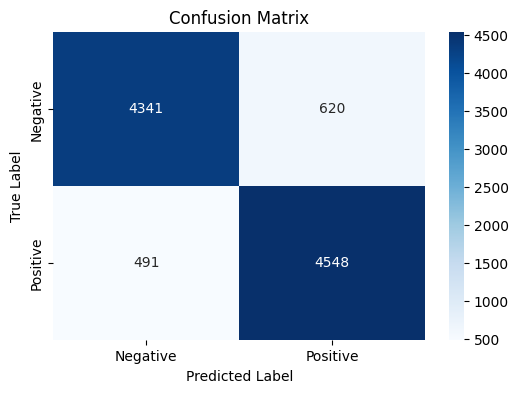

In [11]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [21]:
# Test with emoji example
test_text = "A bit disappointing 😞"
processed_text = clean_text(test_text)
processed_text = remove_stopwords(processed_text)
processed_text = lemmatize_text(processed_text)

# Transform and predict
test_vector = tfidf.transform([processed_text])
prediction = lr.predict(test_vector)[0]
probability = lr.predict_proba(test_vector)[0]

print(f"Original text: {test_text}")
print(f"Processed text: {processed_text}")
print(f"Prediction: {'Positive' if prediction == 1 else 'Negative'}")
print(f"Confidence: {max(probability):.2f}")

Original text: A bit disappointing 😞
Processed text: bit disappointing 😞 😞 disappointed face
Prediction: Negative
Confidence: 0.97
